In [1]:
# Importing libraries
import numpy as np 
import pandas as pd

# for visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# Read the data
house_data = pd.read_csv("data/housing.csv")

In [3]:
# view first five rows
house_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


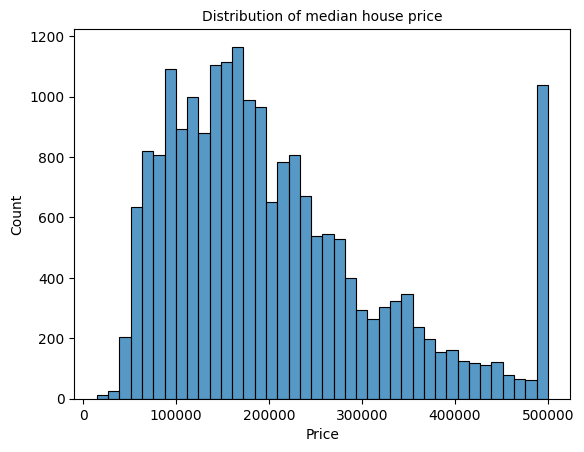

In [4]:
# Distribution of target variable - 'median_house_value'
sns.histplot(x='median_house_value',
            data=house_data[['median_house_value']], bins=40)

plt.title("Distribution of median house price", size=10)
plt.xlabel("Price")
plt.show()

The distribution of housing prices does not show long tail distribution, but it does have a positive/right-skewed distribution.

In [5]:
# Columns
print("Columns::\n" , house_data.columns.tolist())

Columns::
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [6]:
# Feature selection
data = house_data.drop(['ocean_proximity'], axis=1)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


**Question 1** - Find a feature with missing values. How many missing values does it have?

In [7]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

**Question 2** -  What's the median (50% percentile) for variable 'population'?

In [8]:
data['population'].median()

1166.0

### Split the data
- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('median_house_value') is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [9]:
# Split the data
X = data.drop(columns=['median_house_value'], axis=1)
y = data['median_house_value']

# log transformation of y
y = np.log1p(y)

In [10]:
# Number of instances
n = X.shape[0]
n_test = int(n*0.2)
n_val = int(n*0.2)
n_train = int(n - n_test - n_val)

In [11]:
# Create index array.
idx = np.array(X.index)

# shuffle the array.
np.random.seed(42)
np.random.shuffle(idx)

In [12]:
# Splitting data into training, validation and test dataset in ratio 60:20:20 for both X and y.

X_train = X.loc[idx[:n_train]].reset_index(drop=True)
X_val = X.loc[idx[n_train: n_train+n_val]].reset_index(drop=True)
X_test = X.loc[idx[n_train+n_val:]].reset_index(drop=True)

y_train = y.loc[idx[:n_train]].values
y_val = y.loc[idx[n_train: n_train+n_val]].values
y_test = y.loc[idx[n_train+n_val:]].values

In [13]:
# Linear Regression model
def linear_model(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [14]:
# Model evaluation - Root mean squared error
def rmse(y_true, y_preds):
    error = y_true - y_preds
    sq_err = error**2
    return np.sqrt(np.mean(sq_err))

**Question 3**
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [15]:
# Handling missing values in column 'total_bedrooms'.

# first- fill missing values with values '0'.
X_train_0 = X_train.copy()
X_train_0['total_bedrooms'] = X_train_0['total_bedrooms'].fillna(value=0)

X_val_0 = X_val.copy()
X_val_0['total_bedrooms'] = X_val_0['total_bedrooms'].fillna(value=0)


# train the model
w0, w = linear_model(X_train_0, y_train)

# predictions for validation data
y_preds = w0 + X_val_0.dot(w)

# compute the error
score = rmse(y_val, y_preds)
print("RSME Score with values 0::", round(score, 2))

RSME Score with values 0:: 0.33


In [16]:
# first- fill missing values with values it's mean.
X_train_mean = X_train.copy()
X_val_mean = X_val.copy()

mean_val = X_train_mean['total_bedrooms'].mean()
X_train_mean['total_bedrooms'] = X_train_mean['total_bedrooms'].fillna(value=mean_val)
X_val_mean['total_bedrooms'] = X_val_mean['total_bedrooms'].fillna(value=mean_val)

# train the model
w0, w = linear_model(X_train_mean, y_train)

# predictions on validation data
y_preds = w0 + X_val_mean.dot(w)

# compute the error
score = rmse(y_val, y_preds)
print("RMSE Score with mean value::", round(score, 2))

RMSE Score with mean value:: 0.33


**Question 4**
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [17]:
# Regularization 
def linear_model_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [18]:
# Computing root mean squared error with different r values.
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in r_values:
    
    w0, w = linear_model_reg(X_train_0, y_train, r)
    y_preds = w0 + X_val_0.dot(w)
    score = rmse(y_val, y_preds)
    print("r: %f, RSME Score: %.2f" % (r, score))

r: 0.000000, RSME Score: 0.33
r: 0.000001, RSME Score: 0.33
r: 0.000100, RSME Score: 0.33
r: 0.001000, RSME Score: 0.33
r: 0.010000, RSME Score: 0.33
r: 0.100000, RSME Score: 0.33
r: 1.000000, RSME Score: 0.33
r: 5.000000, RSME Score: 0.34
r: 10.000000, RSME Score: 0.34


**Question 5**
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [19]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for s in seeds:
    # shuffle the array.
    np.random.seed(s)
    np.random.shuffle(idx)
    
    # Splitting data into training, validation and test dataset in ratio 60:20:20 for both X and y.
    X_train = X.loc[idx[:n_train]].reset_index(drop=True)
    X_val = X.loc[idx[n_train: n_train+n_val]].reset_index(drop=True)
    X_test = X.loc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = y.loc[idx[:n_train]].values
    y_val = y.loc[idx[n_train: n_train+n_val]].values
    y_test = y.loc[idx[n_train+n_val:]].values
    
    # fill the missing value with '0'.
    X_train_0 = X_train.copy()
    X_val_0 = X_val.copy()
    
    X_train_0['total_bedrooms'].fillna(value=0, inplace=True)
    X_val_0['total_bedrooms'].fillna(value=0, inplace=True)
    
    
    # train model with training data
    w0, w = linear_model(X_train_0, y_train)
    
    # evaluate the model using validation data.
    y_val_predictions = w0 + X_val_0.dot(w)
    
    # compute rmse
    score = rmse(y_val, y_val_predictions)
    scores.append(round(score, 2))
    
    
print(scores)
print(round(np.std(scores), 3))

[0.36, 0.35, 0.35, 0.34, 0.35, 0.33, 0.35, 0.34, 0.34, 0.34]
0.008


**Question 6**
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [20]:
 # shuffle the index array with seed 9 and split the data.
np.random.seed(9)
np.random.shuffle(idx)
    
# Splitting data into training, validation and test dataset in ratio 60:20:20 for both X and y.
X_train = X.loc[idx[:n_train]].reset_index(drop=True)
X_val = X.loc[idx[n_train: n_train+n_val]].reset_index(drop=True)
X_test = X.loc[idx[n_train+n_val:]].reset_index(drop=True)

y_train = y.loc[idx[:n_train]]
y_val = y.loc[idx[n_train: n_train+n_val]]
y_test = y.loc[idx[n_train+n_val:]]

# Combine train and validation datasets.
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0).values

# fill the missing values with 0
X_train['total_bedrooms'].fillna(value=0, inplace=True)
w0, w = linear_model_reg(X_train, y_train, r=0.001)

# predictions
y_preds = w0 + X_train.dot(w)

# RMSE
print("RMSE Score::", round(rmse(y_train, y_preds), 3))

RMSE Score:: 0.34
